In [2]:
import numpy as np
import scipy
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('muted', color_codes=True)
import time
import matplotlib.patches as patches

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
%matplotlib inline

In [4]:
def cloud_maker(x, y, num, size):
    clouds = np.ones_like(x)
    for n in range(num):
        x_pos = np.random.randint(x.shape[0])
        y_pos = np.random.randint(y.shape[0])
        rand_size = np.random.randint(size*.5, size)
        rand_scale = np.random.uniform(.3, 1.7)
        xl = x_pos - rand_size
        if xl < 0:
            xl=0
        xr = x_pos + rand_size
        if xr > x.shape[0]:
            xr = x.shape[0]
        yl = int(y_pos - rand_size*rand_scale)
        if yl < 0:
            yl=0
        yu = int(y_pos + rand_size*rand_scale)
        if yu > x.shape[0]:
            yu = x.shape[0]
        clouds[xl:xr, yl:yu] = 0
    return clouds

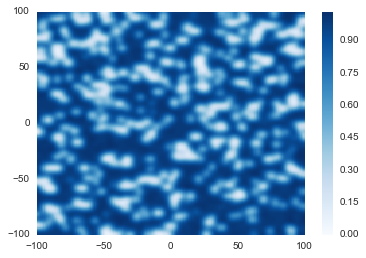

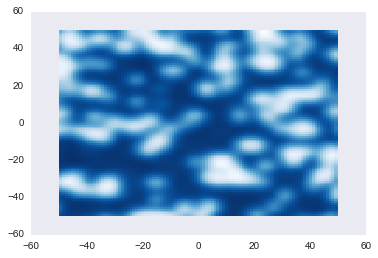

In [5]:
# Big number = 150 size = 11
# Small number = 500 size = 4
big_size = 200
x_big, y_big = np.meshgrid(np.linspace(-big_size/2, big_size/2, big_size),
                           np.linspace(-big_size/2, big_size/2, big_size))
index = int(big_size/2 - 50)
center = slice(index, index + 100)
little_center = slice(index + 20, index + 80)
initial_big = cloud_maker(x_big, y_big, 500, 4)
pert = np.random.normal(loc=0, scale=.1, size = initial_big.size).reshape(initial_big.shape)
initial_big = initial_big + pert
initial_big = initial_big.clip(min=0)
initial_big = gaussian_filter(initial_big, 2.5)
im = plt.pcolormesh(x_big, y_big, initial_big, cmap='Blues', vmin=0)
plt.colorbar(im)
plt.figure()
plt.pcolormesh(x_big[center, center],
               y_big[center, center],
               initial_big[center, center], cmap = 'Blues', shading='gourag')

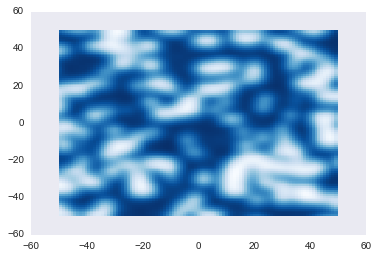

In [6]:
## for loading big initial
initial_big = np.load('/home/travis/twin_results/initial_big.npy')
plt.pcolormesh(x_big[center, center],
               y_big[center, center],
               initial_big[center, center], cmap = 'Blues', shading='gourag')

In [6]:
def time_deriv_2(q, dt, u, dx, v, dy):
    k = space_deriv_2(q, u, dx, v, dy)
    k = space_deriv_2(q + dt/3*k, u, dx, v, dy)
    k = space_deriv_2(q + dt/2*k, u, dx, v, dy)
    qout = q + dt*k
    return qout

In [7]:
def space_deriv_2(q, u, dx, v, dy):
    qout = np.zeros_like(q)
    F_p_x = qout.copy()
    F_n_x = qout.copy()
    F_p_y = qout.copy()
    F_n_y = qout.copy()
    
    #middle
    F_p_x[:, 2:-2] = u[:, 2:-2]/12*(
        7*(q[:, 3:-1] + q[:, 2:-2]) - (q[:, 4:] + q[:, 1:-3]))
    F_n_x[:, 2:-2] = u[:, 1:-3]/12*(
        7*(q[:, 2:-2] + q[:, 1:-3]) - (q[:, 3:-1] + q[:, 0:-4]))
    F_p_y[2:-2, :] = v[2:-2 , :]/12*(
        7*(q[3:-1, :] + q[2:-2, :]) - (q[4:, :] + q[1:-3, :]))
    F_n_y[2:-2, :] = v[1:-3 , :]/12*(
        7*(q[2:-2, :] + q[1:-3, :]) - (q[3:-1, :] + q[0:-4, :]))
    qout = -(F_p_x - F_n_x)/dx - (F_p_y - F_n_y)/dy
    
    #boundaries
    u_w = u[:, 0:2].clip(max=0)
    u_e = u[:, -2:].clip(min=0)
    qout[:, 0:2] = qout[:, 0:2] - (
        (u_w/dx)*(q[:, 1:3] - q[:, 0:2]) + (q[:, 0:2]/dx)*(u[:, 1:3] - u[:, 0:2]))
    qout[:, -2:] = qout[:, -2:] - (
        (u_e/dx)*(q[:, -2:] - q[:, -3:-1]) + (q[:, -2:]/dx)*(u[:, -2:] - u[:, -3:-1]))
    
    v_n = v[-2:, :].clip(min=0)
    v_s = v[0:2, :].clip(max=0)
    qout[0:2, :] = qout[0:2, :] - (
        (v_s/dx)*(q[1:3, :] - q[0:2, :]) + (q[0:2, :]/dx)*(v[1:3, :] - v[0:2, :]))
    qout[-2:, :] = qout[-2:, :] - (
        (v_n/dx)*(q[-2:, :] - q[-3:-1, :]) + (q[-2:, :]/dx)*(v[-2:, :] - v[-3:-1, :]))
    
    
    return qout

In [8]:
## for Big
sensor_num = 20
positions = np.random.randint(30, 70, sensor_num*2).reshape(2, sensor_num)
H = np.zeros_like(initial_big[center, center])
H[positions[0],positions[1]]=1
H = H.reshape(H.size)
H = np.diag(H)
H = H[~np.all(H == 0, axis=1)]
# H = np.concatenate([np.zeros([sensor_num, 2]), H], axis = 1)
print(H.sum())
print(H.shape)
# size = initial_big[center, center].size
# H_15 = np.concatenate([np.zeros([size, 2]), np.eye(size)], axis = 1)
# print(H_15.sum())
# print(H_15.shape)

20.0
(20, 10000)


In [ ]:
## to save positions
# np.save('/home/travis/twin_results/positions', positions)

In [14]:
##to load positions
positions = np.load('/home/travis/twin_results/positions.npy')

In [ ]:
noise_init[40,20]

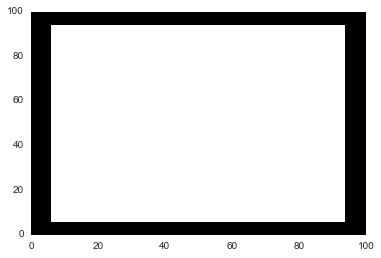

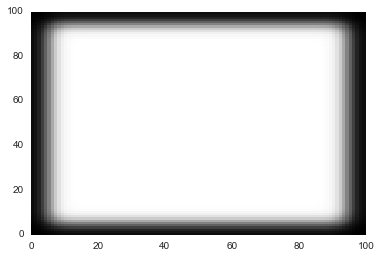

In [9]:
noise_init = np.zeros_like(initial_big[center, center])
noise_init[0:6, :] = 1
noise_init[-6:, :] = 1
noise_init[:, 0:6] = 1
noise_init[:, -6:] = 1
plt.pcolormesh(noise_init)
noise_init = gaussian_filter(noise_init, 3)
plt.figure()
plt.pcolormesh(noise_init)

7.07099044715
7.07096570753


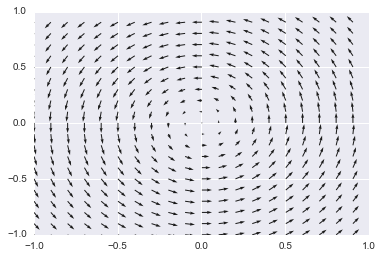

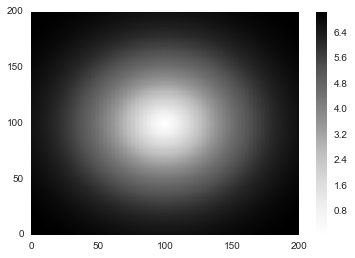

In [10]:
x, y = np.meshgrid(np.linspace(-1, 1, big_size*2), np.linspace(-1, 1, big_size*2))
#x, y = np.meshgrid(np.linspace(-1, 1, 2*q_length - 1), np.linspace(-1, 1, 2*q_length - 1))
U = -y/(x**2 + y**2 +.05)*2
V = x/(x**2 + y**2 + .05)*2
# U = -y/(x**2 + y**2 +.05) + .75
# V = x/(x**2 + y**2 +.05) + .75
U = -y/(x**2 + y**2 + .5)*10
V = x/(x**2 + y**2 + .5)*10
u_vor = U[0::2, 1::2]
v_vor = V[1::2, 0::2]
print(u_vor.max())
print(v_vor.max())
every = 20
plt.figure()
plt.quiver(x[::every,::every], y[::every, ::every], U[::every,::every], V[::every,::every])

mag = np.sqrt(U**2 + V**2)
plt.figure()
im = plt.pcolormesh(mag[100:300, 100:300])
plt.colorbar(im)

In [11]:
def nearest_positions(loc, shape, dist):
    ## the shape has to be square
    position = np.unravel_index(loc, shape)
    row_min = (position[0] - dist).clip(min = 0)
    row_max = (position[0] + dist).clip(max = (shape[0] - 1))
    col_min = (position[1] - dist).clip(min = 0)
    col_max = (position[1] + dist).clip(max = (shape[1] - 1))
    row_positions, col_positions = np.meshgrid(np.arange(row_min, row_max + 1), 
                                               np.arange(col_min, col_max + 1))
    row_positions = np.ravel(row_positions)
    col_positions = np.ravel(col_positions)
    near_positions = np.ravel_multi_index((row_positions, col_positions), shape)
    near_positions.sort()
    return near_positions

In [ ]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

time for set up: 0.00039290189743041993
time to finish adv5.0 is 0.044503156344095865
time to finish kalman5.0 is 0.0011203408241271973


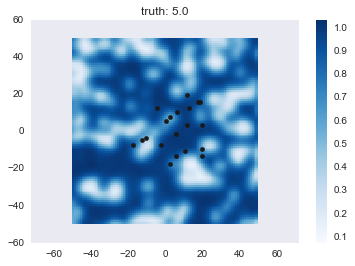

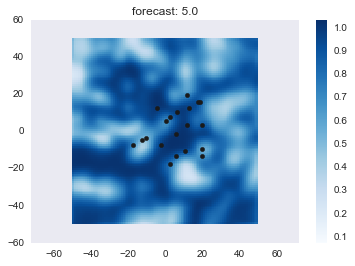

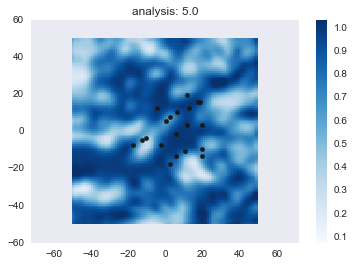

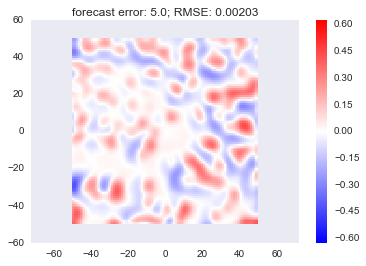

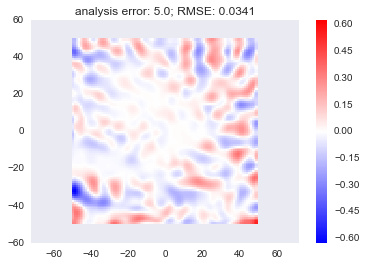

time to finish adv10.0 is 0.38455054759979246
time to finish kalman10.0 is 0.002546326319376628


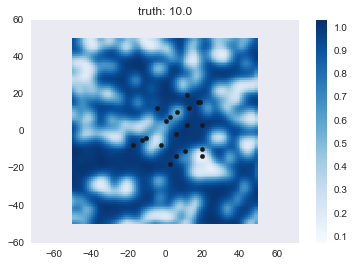

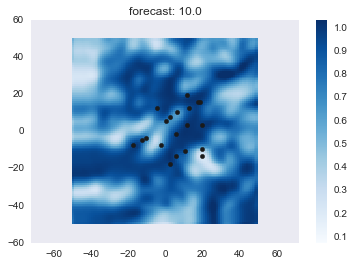

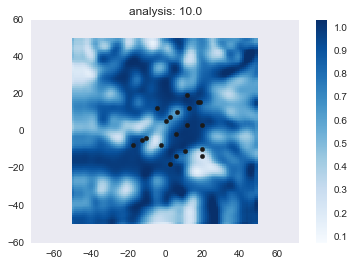

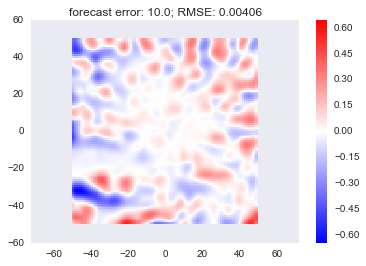

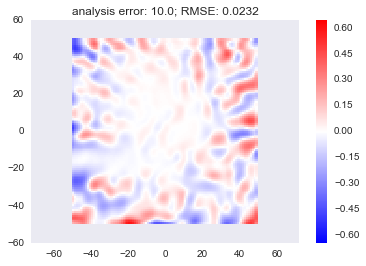

time to finish adv15.0 is 0.14060400327046713
time to finish kalman15.0 is 0.040653260548909505


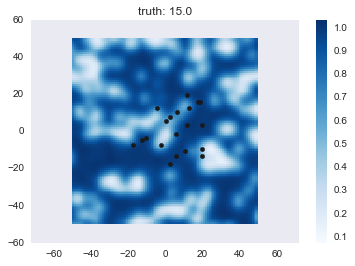

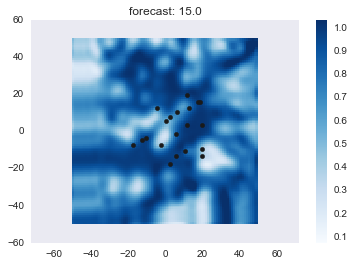

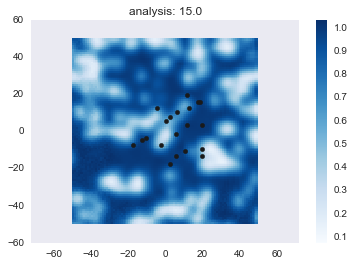

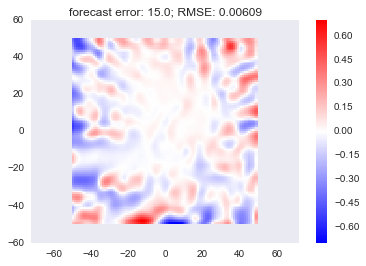

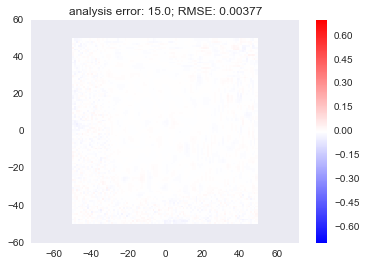

time to finish adv20.0 is 0.1358861247698466
time to finish kalman20.0 is 0.0026277860005696615


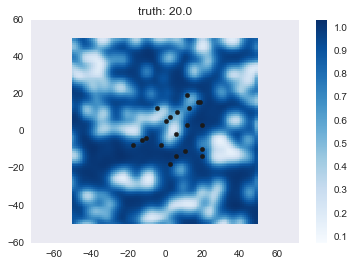

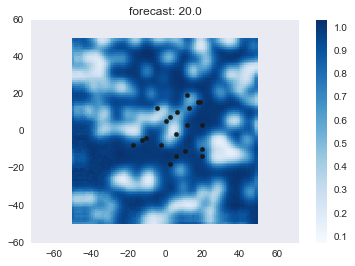

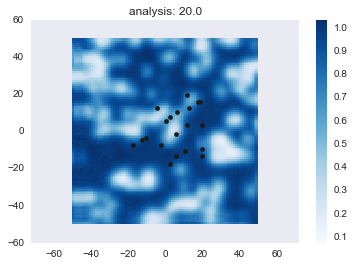

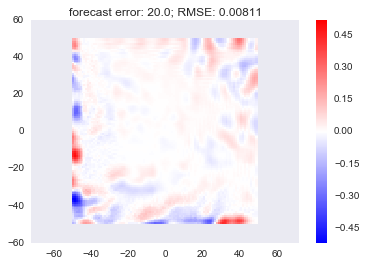

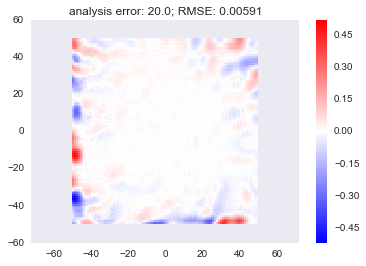

time to finish adv25.0 is 0.13375725746154785
time to finish kalman25.0 is 0.002557965119679769


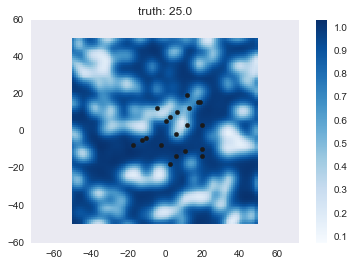

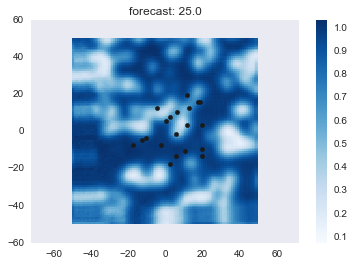

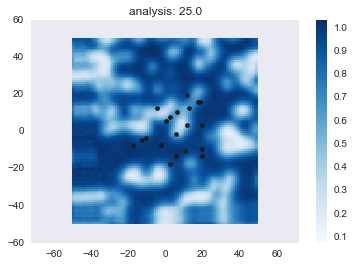

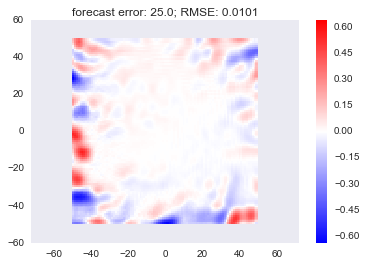

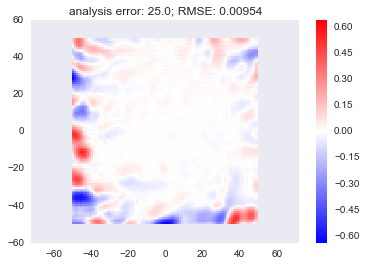

time to finish adv30.0 is 0.13059359788894653
time to finish kalman30.0 is 0.05089837312698364


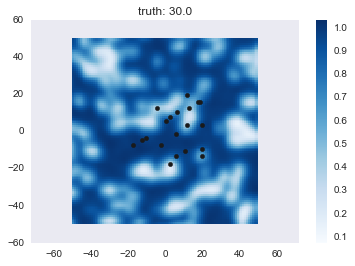

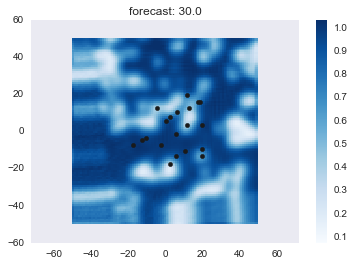

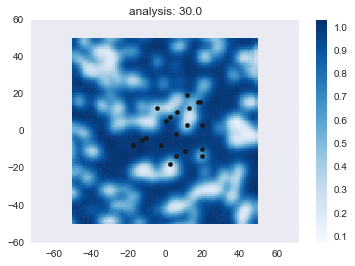

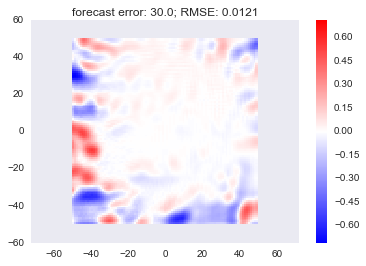

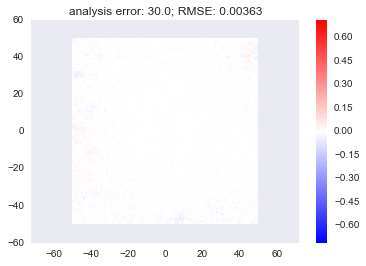

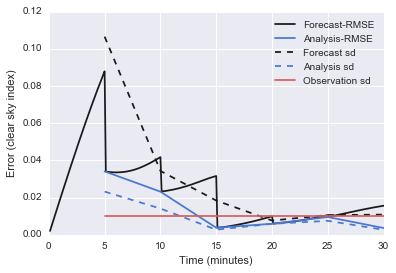

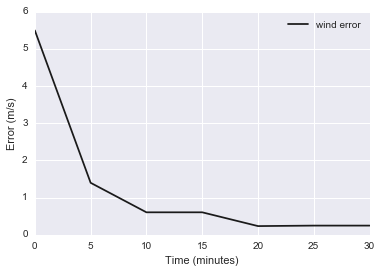

In [12]:
## 4 vec
## Fixed the wind ensemble bug in this one
## localization with noise to ignore 
## unknown vortex with unknown 2 component windfeild
## LETKF on 5 minute EnKF(no wind) on 15
time_start = time.time()

## Parameters
# wind_smoothing = 4 # not needed for 2X2 wind
# noise_scale = 0.1 # not used?
number_of_updates = 6 # each of 5 min length
u_speed = 15
v_speed = 10
u_accel = 0
v_accel = 0
wind_scale_err = .6 # multiplied by true constant wind to get model constant wind
ens_size = 20
wind_disc_num = 2 # number of winds per side
sig_obs = .01 # standar deviation of observation error
dx = 1000 
dy = 1000
C_max = .7
count = 0
plot_count = 0
little_center = 30
little_little_center = slice(little_center, 100 - little_center)
kalman_grid_size = 3 # factor of 99
dist = 3
inflation = 1.7

## loaded values
noise = noise_init.copy()
true = initial_big.copy()
x = x_big[center, center]
y = y_big[center, center]
vmax = initial_big.max()
vmin = initial_big.min()


## computed values
size = initial_big[center, center].size
shape = initial_big[center, center].shape
shape_big = initial_big.shape
u_true = u_vor + u_speed
v_true = v_vor + v_speed
wind_size = int(2*wind_disc_num**2)

# H_cust = np.concatenate([np.zeros([size, wind_size]), np.eye(size)], axis=1) unused in LETKF

## initializations
# RMSE_f = np.ones(number_of_updates)*np.nan
RMSE_a = np.ones(number_of_updates)*np.nan
RMSE_f_median = np.ones(number_of_updates)*np.nan
RMSE_a_median = np.ones(number_of_updates)*np.nan
wind_err = np.ones(number_of_updates + 1)*np.nan
trace_Pf = np.ones(number_of_updates)*np.nan
trace_Pa = np.ones(number_of_updates)*np.nan

## ensemble creation
ensemble = np.random.normal(
    loc=0,
    scale=u_speed,
    size=ens_size*wind_size).reshape(wind_size, ens_size)
ensemble = np.concatenate(
    [ensemble, np.repeat(initial_big[center, center].reshape(size, 1),
                         ens_size, axis=1)], axis=0)


## wind creation

u_ens = np.zeros([shape[0], shape[1], ens_size])
v_ens = u_ens.copy()
index_range = np.arange(100)
x_R = np.array([0, 99])
y_R = np.array([0, 99])
for ii in range(ens_size):
    u_fun = scipy.interpolate.RectBivariateSpline(
        x_R, y_R, ensemble[0:int(wind_size/2), ii].reshape(
            wind_disc_num, wind_disc_num),
        kx=1, ky=1)
    v_fun = scipy.interpolate.RectBivariateSpline(
        x_R, y_R, ensemble[int(wind_size/2): wind_size, ii].reshape(
            wind_disc_num, wind_disc_num),
        kx=1, ky=1)
    u_ens[:, :, ii] = u_fun(index_range, index_range)
    v_ens[:, :, ii] = v_fun(index_range, index_range)

## Numerics computations
cx = abs(u_true).max() + ensemble[0:wind_size].max()
cy = abs(v_true).max() + ensemble[0:wind_size].max()
N = np.ceil((5*60)*(cx/dx+cy/dy)/C_max)
dt = (5*60)/N
T = 5*number_of_updates*60
T_steps = int(np.ceil(T/dt))    
    
## new initializations
RMSE_f = np.ones(T_steps)*np.nan
analysis = np.ones([number_of_updates, shape[0], shape[1]])*np.nan
background = np.ones([number_of_updates, shape[0], shape[1]])*np.nan
truth_saved = np.ones([number_of_updates, shape[0], shape[1]])*np.nan
biased_sat = np.ones([int(number_of_updates/3), shape[0], shape[1]])*np.nan
corrected_sat = np.ones([int(number_of_updates/3), shape[0], shape[1]])*np.nan
u_mean = np.ones([number_of_updates + 1, shape[0], shape[1]])*np.nan
v_mean = np.ones([number_of_updates + 1, shape[0], shape[1]])*np.nan
u_mean[0] = u_ens.mean(axis=2) + u_speed*wind_scale_err
v_mean[0] = v_ens.mean(axis=2) + v_speed*wind_scale_err


## Kalman interpolation computations
row_positions, col_positions = np.meshgrid(np.arange(0, shape[0], kalman_grid_size),
                                           np.arange(0, shape[0], kalman_grid_size))
row_positions = np.ravel(row_positions)
col_positions = np.ravel(col_positions)
kalman_positions = np.ravel_multi_index((row_positions, col_positions), shape)
kalman_positions.sort()
kalman_positions_2d = np.unravel_index(kalman_positions, shape)
kalman_positions_2d = np.stack(
    [kalman_positions_2d[0], kalman_positions_2d[1]], axis=1)
full_positions_2d = np.unravel_index(np.arange(0, size), shape)
full_positions_2d = np.stack(
    [full_positions_2d[0], full_positions_2d[1]], axis=1)
W_interp = np.zeros([kalman_positions.size, ens_size**2])

## Initial Errors
wind_err[0] = np.sqrt(
            (((u_ens[little_little_center, little_little_center].mean(axis=2) + 
               u_speed*wind_scale_err - u_true[center, center][little_little_center, little_little_center])**2).mean() + 
             ((v_ens[little_little_center, little_little_center].mean(axis=2) + 
               v_speed*wind_scale_err - v_true[center, center][little_little_center, little_little_center])**2).mean())/2)

time_set_up_done = time.time()
print('time for set up: ' + str((time_set_up_done - time_start)/60))
time_kalman_finish = time_set_up_done
for t in range(T_steps):
    for ii in range(ens_size):
        ensemble[wind_size::, ii] = time_deriv_2(
            ensemble[wind_size::, ii].reshape(shape), dt,
            u_ens[:, :, ii] + u_speed*wind_scale_err,
            dx, v_ens[:, :, ii] + v_speed*wind_scale_err, dy).reshape(size)
    true = time_deriv_2(true, dt, u_true, dx, v_true, dy)
    noise = time_deriv_2(noise, dt, u_true[center, center],
                         dx, v_true[center, center], dy)
    
    average_f = ensemble[wind_size::].mean(axis=1).reshape(shape)
    error_f = average_f - true[center, center]
    RMSE_f[t] = np.sqrt(np.mean(error_f[little_little_center,
                                                little_little_center]**2))
    
    u_speed += u_accel*dt
    v_speed += v_accel*dt
    #q = time_deriv_2cyc(q, dt, u, dx, v, dy)
    nearest_up = 5*np.round((t+1)*dt/(60*5))
    test = abs(nearest_up-(t+1)*dt/60) < abs(nearest_up-(t+2)*dt/60)
    test = test and abs(nearest_up-(t+1)*dt/60) < abs(nearest_up-(t)*dt/60)
    if nearest_up != 0 and test:
        time_kalman_start = time.time()
        print('time to finish adv' + str(nearest_up) + ' is '
              + str((time_kalman_start - time_kalman_finish)/60))
        average_f = ensemble[wind_size::].mean(axis=1).reshape(shape)
        error_f = average_f - true[center, center]
#         RMSE_f[count] = np.sqrt(np.mean(error_f[little_little_center,
#                                                 little_little_center]**2))
        
        background[count] = average_f
        truth_saved[count] = true[center, center]
        
        median_f = np.median(ensemble[wind_size::], axis=1).reshape(shape)
        error_f_median = median_f - true[center, center]
        RMSE_f_median[count] = np.sqrt(np.mean(error_f_median[little_little_center,
                                                little_little_center]**2))
        if nearest_up%15 == 0:
            
#             plt.figure()
#             im = plt.pcolormesh(x, y, noise, cmap='bwr')
#             plt.colorbar(im)
#             plt.title('Noise: {}'.format(round((t+1)*dt)/60))
#             plt.axis('equal')
#             plt.show()
            
            # LETKF with localization
            P = np.var(ensemble[wind_size::], axis=1)
            temp = P.reshape(shape)[little_little_center, little_little_center]
            trace_Pf[count] = np.mean(np.sqrt(temp))
            
            flat_noise = (noise - noise.min())
            flat_noise = flat_noise/flat_noise.max()
#             flat_noise = flat_noise*9 + 1 # garbage areas equal 10 clean equals 1
            flat_noise = np.ravel(flat_noise)
            y_obs = (np.ravel(true[center, center]) + 
                     np.random.normal(loc=0, scale=sig_obs, size=size))
            ensemble[wind_size:, :] = (y_obs[:, None]*flat_noise[:, None] +
                                       ensemble[wind_size:, :]*(1 - flat_noise[:, None]))
            x_bar = ensemble.mean(axis=1) 
            ensemble -= x_bar[:, np.newaxis] # Y_b is ensemble[wind_size::, :]
            
            
        
#             ## localization NO interpolation
#             for this_position in kalman_positions:
#                 local_positions = nearest_positions(this_position, shape, dist)
#                 local_ensemble = ensemble[local_positions + wind_size]
#                 local_x_bar = x_bar[local_positions + wind_size]
#                 local_obs = y_obs[local_positions]
#                 local_noise = flat_noise[local_positions]
#                 C = (local_ensemble.T)/(sig_obs**2)
#                 #C = C*local_noise[None, :]
#                 P_a = np.linalg.inv((ens_size - 1)*np.eye(ens_size) +
#                                     C.dot(local_ensemble))
#                 W_a = np.real(scipy.linalg.sqrtm((ens_size - 1)*P_a))
#                 w_a_bar = P_a.dot(C.dot(local_obs - local_x_bar))
#                 W_a += w_a_bar[:, None]
#                 ensemble[this_position, :] = (
#                     x_bar[this_position, None] + 
#                     ensemble[this_position, :].dot(W_a))
#             ensemble[0:wind_size, :] += x_bar[0:wind_size, None]
#             ## localization NO interpolation
            
            ## localization with interpolation
            kal_count = 0
            for interp_position in kalman_positions:
                local_positions = nearest_positions(interp_position, shape, dist)
                local_ensemble = ensemble[local_positions + wind_size]
                local_x_bar = x_bar[local_positions + wind_size]
                local_obs = y_obs[local_positions]
                local_noise = flat_noise[local_positions]
                C = (local_ensemble.T)/(sig_obs**2)
#                 C = C*local_noise[None, :]
#                 P_a = np.linalg.inv((ens_size - 1)*np.eye(ens_size)/flat_noise[interp_position] +
#                                     C.dot(local_ensemble)) # with noise inflation
                P_a = np.linalg.inv((ens_size - 1)*np.eye(ens_size)/inflation +
                                    C.dot(local_ensemble)) # withOUT noise inflation
                W_a = np.real(scipy.linalg.sqrtm((ens_size - 1)*P_a))
                w_a_bar = P_a.dot(C.dot(local_obs - local_x_bar))
                W_a += w_a_bar[:, None]
                W_interp[kal_count] = np.ravel(W_a) ## separate w_bar??
                kal_count += 1
                
            W_fun = scipy.interpolate.LinearNDInterpolator(kalman_positions_2d, W_interp)
            W_fine_mesh = W_fun(full_positions_2d)
            W_fine_mesh = W_fine_mesh.reshape(size, ens_size, ens_size)
            ensemble[wind_size::] = x_bar[wind_size::, None] + np.einsum('ij, ijk->ik', ensemble[wind_size::], W_fine_mesh)
            ensemble[0:wind_size] += x_bar[0:wind_size, None]
            ## localization with interpolation
            noise = noise_init.copy()
            
            u_mean[count + 1] = u_ens.mean(axis=2) + u_speed*wind_scale_err
            v_mean[count + 1] = v_ens.mean(axis=2) + v_speed*wind_scale_err
            
        else:
            # H only maps irradiance map to sensors, must maually remove wind
            P = np.var(ensemble[wind_size::], axis=1)
            temp = P.reshape(shape)[little_little_center, little_little_center]
            trace_Pf[count] = np.mean(np.sqrt(temp))
            y_obs = (H.dot(true[center, center].reshape(size)) + 
                 np.random.normal(loc=0, scale=sig_obs, size=sensor_num))
            Y_b = np.einsum('ij,jk...->ik...', H, ensemble[wind_size::, :])
            y_b_bar = Y_b.mean(axis=1)
            Y_b -= y_b_bar[:, np.newaxis]
            x_bar = ensemble.mean(axis=1)
            ensemble -= x_bar[:, np.newaxis]
            R = np.diag(np.ones(sensor_num)*sig_obs**2)
            C = np.linalg.solve(R.T, Y_b).T
            P_a = np.linalg.inv((ens_size-1)*np.eye(ens_size)/inflation + C.dot(Y_b))
            W_a = np.real(scipy.linalg.sqrtm((ens_size - 1)*P_a))
            w_a_bar = P_a.dot(C.dot(y_obs - y_b_bar))
            W_a += w_a_bar[:, np.newaxis]
            ensemble = x_bar[:, np.newaxis] + ensemble.dot(W_a)
            for ii in range(ens_size):
#                 wind_fun = scipy.interpolate.LinearNDInterpolator(
#                     points, np.stack([ensemble[0:wind_size/2, ii], ensemble[wind_size/2:wind_size, ii]], axis=1))
#                 winds_temp = wind_fun(full_points)
#                 u_ens[:, :, ii] = winds_temp[:, 0].reshape(shape)
#                 v_ens[:, :, ii] = winds_temp[:, 1].reshape(shape)
#                 u_ens[:, :, ii] = gaussian_filter(u_ens[:, :, ii], wind_smoothing)
#                 v_ens[:, :, ii] = gaussian_filter(v_ens[:, :, ii], wind_smoothing)
                u_fun = scipy.interpolate.RectBivariateSpline(
                    x_R, y_R, ensemble[0:int(wind_size/2), ii].reshape(
                        wind_disc_num, wind_disc_num),
                    kx=1, ky=1)
                v_fun = scipy.interpolate.RectBivariateSpline(
                    x_R, y_R, ensemble[int(wind_size/2): wind_size, ii].reshape(
                        wind_disc_num, wind_disc_num),
                    kx=1, ky=1)
                u_ens[:, :, ii] = u_fun(index_range, index_range)
                v_ens[:, :, ii] = v_fun(index_range, index_range)
            
            u_mean[count + 1] = u_ens.mean(axis=2) + u_speed*wind_scale_err
            v_mean[count + 1] = v_ens.mean(axis=2) + v_speed*wind_scale_err
            
            
    
#             y_obs = (H[:, 2::].dot(true[center, center].reshape(size)) + 
#                  np.random.normal(loc=0, scale=sig_obs, size=sensor_num))
#             R = np.diag(np.ones(sensor_num)*sig_obs)
#             P = np.cov(ensemble)
#             temp = P[2::,2::].diagonal().reshape(shape)[little_center, little_center]
#             trace_Pf[count] = np.sqrt(np.mean(temp))
#             # K = P.dot(H.T.dot(np.linalg.inv(H.dot(P.dot(H.T)) + R)))
#             K = np.linalg.solve((H.dot(P.dot(H.T))) + R, H.dot(P.T)).T
#             for ii in range(ens_size): #replace as matrix mult
#                 ensemble[:, ii] = ensemble[:, ii] + K.dot(
#                     y_obs + np.random.normal(loc=0, scale=sig_obs, size=sensor_num) - 
#                     H.dot(ensemble[:, ii]))
        time_kalman_finish = time.time()
        print('time to finish kalman' + str(nearest_up) + ' is '
              + str((time_kalman_finish - time_kalman_start)/60))
        
        wind_err[count + 1] = np.sqrt(
            (((u_ens[little_little_center, little_little_center].mean(axis=2) + 
               u_speed*wind_scale_err - u_true[center, center][little_little_center, little_little_center])**2).mean() + 
             ((v_ens[little_little_center, little_little_center].mean(axis=2) + 
               v_speed*wind_scale_err - v_true[center, center][little_little_center, little_little_center])**2).mean())/2)
    
        temp = np.cov(ensemble[wind_size::, :]).diagonal().reshape(shape)[little_little_center, 
                                                                  little_little_center]
        trace_Pa[count] = np.mean(np.sqrt(temp))
        
        average_a = ensemble[wind_size::].mean(axis=1).reshape(shape)
        error_a = average_a - true[center, center]
        RMSE_a[count] = np.sqrt(np.mean(error_a[little_little_center,
                                                little_little_center]**2))
        
        analysis[count] = average_a
        
        median_a = np.median(ensemble[wind_size::], axis=1).reshape(shape)
        error_a_median = median_a - true[center, center]
        RMSE_a_median[count] = np.sqrt(np.mean(error_a_median[little_little_center,
                                                little_little_center]**2))
        
        error_vmax = max([abs(error_a).max(), abs(error_f).max()])
        
        
        plt.figure()
        im = plt.pcolormesh(x, y, true[center, center], vmax=vmax, vmin=vmin, cmap='Blues')
        plt.colorbar(im)
        plt.scatter(x[0, positions[0, :]], y[positions[1, :], 0], color='k')
        plt.title('truth: {}'.format(round((t+1)*dt)/60))
        plt.axis('equal')
        plt.show()
        
        plt.figure()
        im = plt.pcolormesh(x, y, average_f, vmax=vmax, vmin=vmin, cmap='Blues')
        plt.colorbar(im)
        plt.scatter(x[0, positions[0, :]], y[positions[1, :], 0], color='k')
        plt.title('forecast: {}'.format(round((t+1)*dt)/60))
        plt.axis('equal')
        plt.show()
        
        plt.figure()
        im = plt.pcolormesh(x, y, average_a, vmax=vmax, vmin=vmin, cmap='Blues')
        plt.colorbar(im)
        plt.scatter(x[0, positions[0, :]], y[positions[1, :], 0], color='k')
        plt.title('analysis: {}'.format(round((t+1)*dt)/60))
        plt.axis('equal')
        plt.show()
        
        plt.figure()
        im = plt.pcolormesh(x, y, error_f, vmax=error_vmax, vmin=-error_vmax, cmap='bwr')
        plt.colorbar(im)
        plt.title('forecast error: {time}; RMSE: {rmse:.3}'.format(
        time=round((t+1)*dt)/60, rmse=RMSE_f[count]))
        plt.axis('equal')
        plt.show()
        
        plt.figure()
        im = plt.pcolormesh(x, y, error_a, vmax=error_vmax, vmin=-error_vmax, cmap='bwr')
        plt.colorbar(im)
        plt.title('analysis error: {time}; RMSE: {rmse:.3}'.format(
        time=round((t+1)*dt)/60, rmse=RMSE_a[count]))
        plt.axis('equal')
        plt.show()
        
        

        
        count += 1
    
#     f, ((ax1),(ax2)) = plt.subplots(1,2, figsize=(9,5), frameon=False)
#     ax1.pcolormesh(x, y, true[center, center], vmax=vmax, vmin=vmin, cmap='Blues', shading='gourag')
#     ax1.set_title('Truth at time: {0:5.2f}'.format(round((t+1)*dt)/60), fontdict={'fontsize':20})
#     ax1.axis('equal')
#     ax1.axis('off')

#     median_a = np.mean(ensemble[wind_size::], axis=1).reshape(shape)
#     ax2.pcolormesh(x, y, median_a, vmax=vmax, vmin=vmin, cmap='Blues', shading='gourag')
#     ax2.set_title('Ensemble mean', fontdict={'fontsize':20})
#     ax2.axis('equal')
#     ax2.axis('off')

#     rect1 = patches.Rectangle((-20,-20), 40, 40, linewidth=1, edgecolor='k', facecolor='none')
#     rect2 = patches.Rectangle((-20,-20), 40, 40, linewidth=1, edgecolor='k', facecolor='none')
#     ax2.add_patch(rect2)
#     ax1.add_patch(rect1)

#     plt.savefig('/home/travis/twin_results/movie_4vec/fig{0:04}.png'.format(plot_count), format='png')
#     plt.close('all')

#     plot_count += 1
    

plt.figure()
# plt.plot(5*(np.arange(number_of_updates)+1), RMSE_f, color='k')
# plt.plot(5*(np.arange(number_of_updates)+1), RMSE_a, color='b')
plt.plot((dt/60)*(np.arange(T_steps)+1), RMSE_f, color='k')
plt.plot(5*(np.arange(number_of_updates)+1), RMSE_a, color='b')
plt.plot(5*(np.arange(number_of_updates)+1), trace_Pf, color='k', linestyle='--')
plt.plot(5*(np.arange(number_of_updates)+1), trace_Pa, color='b', linestyle='--')
plt.plot(5*(np.arange(number_of_updates)+1), np.ones_like(trace_Pa)*sig_obs, color='r')
plt.legend(['Forecast-RMSE', 'Analysis-RMSE', 'Forecast sd', 'Analysis sd', 'Observation sd' ])
plt.xlabel('Time (minutes)')
plt.ylabel('Error (clear sky index)')
# plt.savefig('/home/travis/forecasting/movie_1vec_new/RMSE.png', format='png')
# plt.close('all')


plt.figure()
plt.plot(5*(np.arange(number_of_updates + 1)), wind_err, color='k')
plt.legend(['wind error'], loc = 'upper right')
plt.xlabel('Time (minutes)')
plt.ylabel('Error (m/s)')
# plt.savefig('/home/travis/forecasting/movie_1vec_new/U_error.png', format='png')
# plt.close('all')

# np.save('/home/travis/twin_results/4_vec/background', background)
# np.save('/home/travis/twin_results/4_vec/analysis', analysis)
# np.save('/home/travis/twin_results/4_vec/truth', truth_saved)
# np.save('/home/travis/twin_results/4_vec/biased_sat', biased_sat)
# np.save('/home/travis/twin_results/4_vec/corrected_sat', corrected_sat)
# np.save('/home/travis/twin_results/4_vec/wind_err', wind_err)
# np.save('/home/travis/twin_results/4_vec/RMSE_f', RMSE_f)
# np.save('/home/travis/twin_results/4_vec/RMSE_a', RMSE_a)
# np.save('/home/travis/twin_results/4_vec/trace_Pf', trace_Pf)
# np.save('/home/travis/twin_results/4_vec/trace_Pa', trace_Pa)
# np.save('/home/travis/twin_results/4_vec/u_mean', u_mean)
# np.save('/home/travis/twin_results/4_vec/v_mean', v_mean)